




# DATA ANALYSIS REPORT FOR WINE RATING PREDICTOR ML MODEL





Importing the files necessary for our Data Analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Plot / Graph stuffs
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


Here we check for the lenght of the dataframe before removing the duplicates

In [2]:
init_data = pd.read_csv("../data_root/raw/wine_dataset.csv")
print("Length of dataframe before duplicates are removed:", len(init_data))

Length of dataframe before duplicates are removed: 10000


Datasets often will have duplicate values and its necesssary to remove those to do proper analysis and obtain accurate predictions. Here we can observe the difference in the size of the dataframe once we remove the unnecessary duplicate and null values.

In [3]:
#Removing Duplicates from input file
parsed_data = init_data[init_data.duplicated('description', keep=False)]
print("Length of dataframe after duplicates are removed:", len(parsed_data))
#Removing Null Values from input file
parsed_data.dropna(subset=['description', 'points'])
print("Length of dataframe after NaNs are removed:", len(parsed_data))

Length of dataframe after duplicates are removed: 116
Length of dataframe after NaNs are removed: 116


We reanalyze the cleaned data, again on the basis of a description vs points model.

In [4]:
#Analysing the data based on a description vs points model
dp = parsed_data[['description','points']]
dp.info()
dp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 175 to 9825
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  116 non-null    object
 1   points       116 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.7+ KB


,description,points
175,"So ripe and lush with fruit, this could only b...",92
506,"Despite the low alcohol reading, this comes ac...",90
555,"Coffee grinds, raisin and baked aromas suggest...",87
610,Aromas of black cherry and green pepper lead i...,87
632,This pale salmon rosé is a reliable sparkling ...,90


Inspecting the plot containing the number of wines per point, we can observe that there are a lot of wines in the range of 85-92 points, with a slight dip in 91. This correlates with an abundance of average wines, as we can see from the present market.

<AxesSubplot:title={'center':'Number of wines per points'}, xlabel='points', ylabel='Number of wines'>

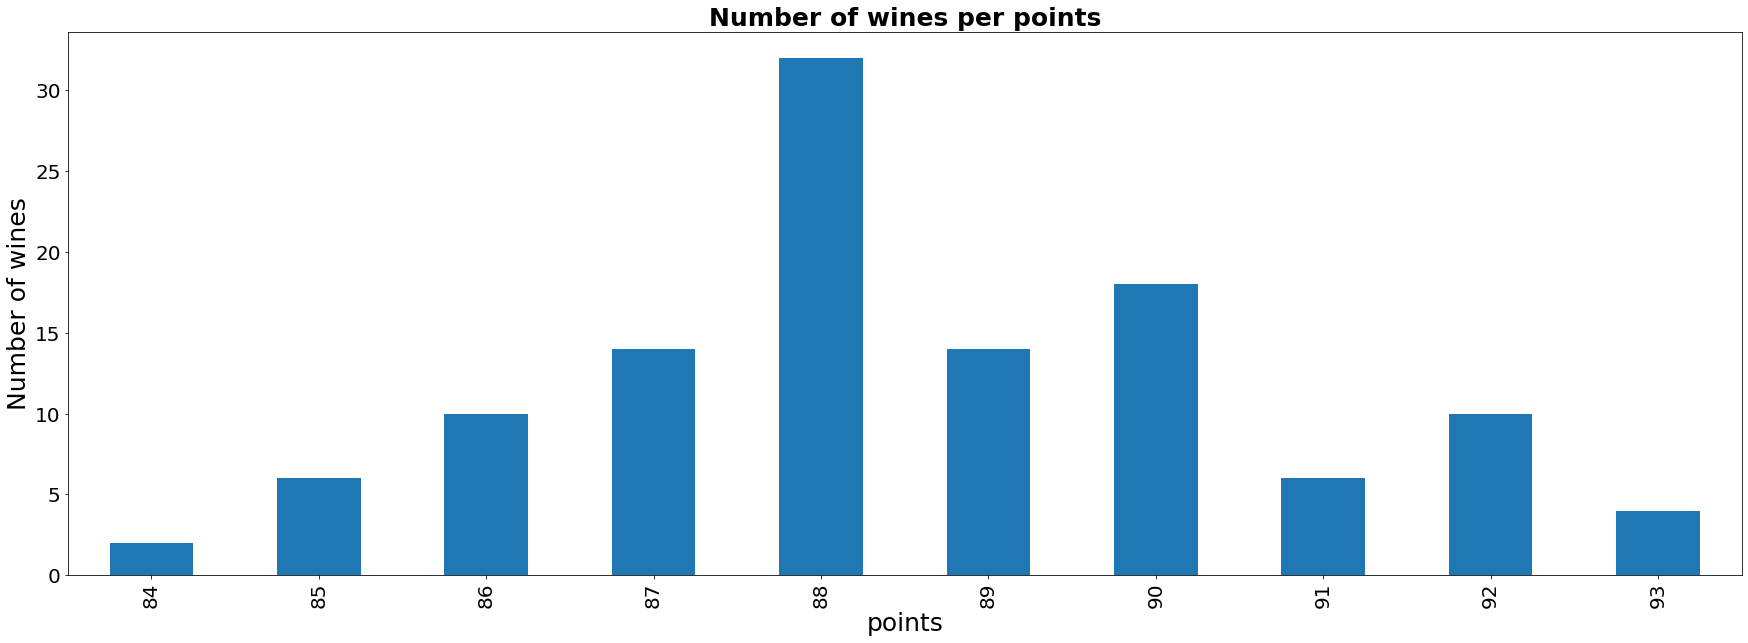

In [5]:
#Inspecting the distribution of wines per points

fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of wines per points', fontweight="bold", size=25) # Title
ax.set_ylabel('Number of wines', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
dp.groupby(['points']).count()['description'].plot(ax=ax, kind='bar')

It is possible that the better the quality of wine, the longer its description could be. Plotting the the quality of wine along side the lenght of its description in a graph will give us a better idea of this assumption.

In [6]:
dp = dp.assign(description_length = dp['description'].apply(len))
dp.info()
dp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 175 to 9825
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   description         116 non-null    object
 1   points              116 non-null    int64 
 2   description_length  116 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ KB


,description,points,description_length
175,"So ripe and lush with fruit, this could only b...",92,344
506,"Despite the low alcohol reading, this comes ac...",90,210
555,"Coffee grinds, raisin and baked aromas suggest...",87,232
610,Aromas of black cherry and green pepper lead i...,87,258
632,This pale salmon rosé is a reliable sparkling ...,90,230


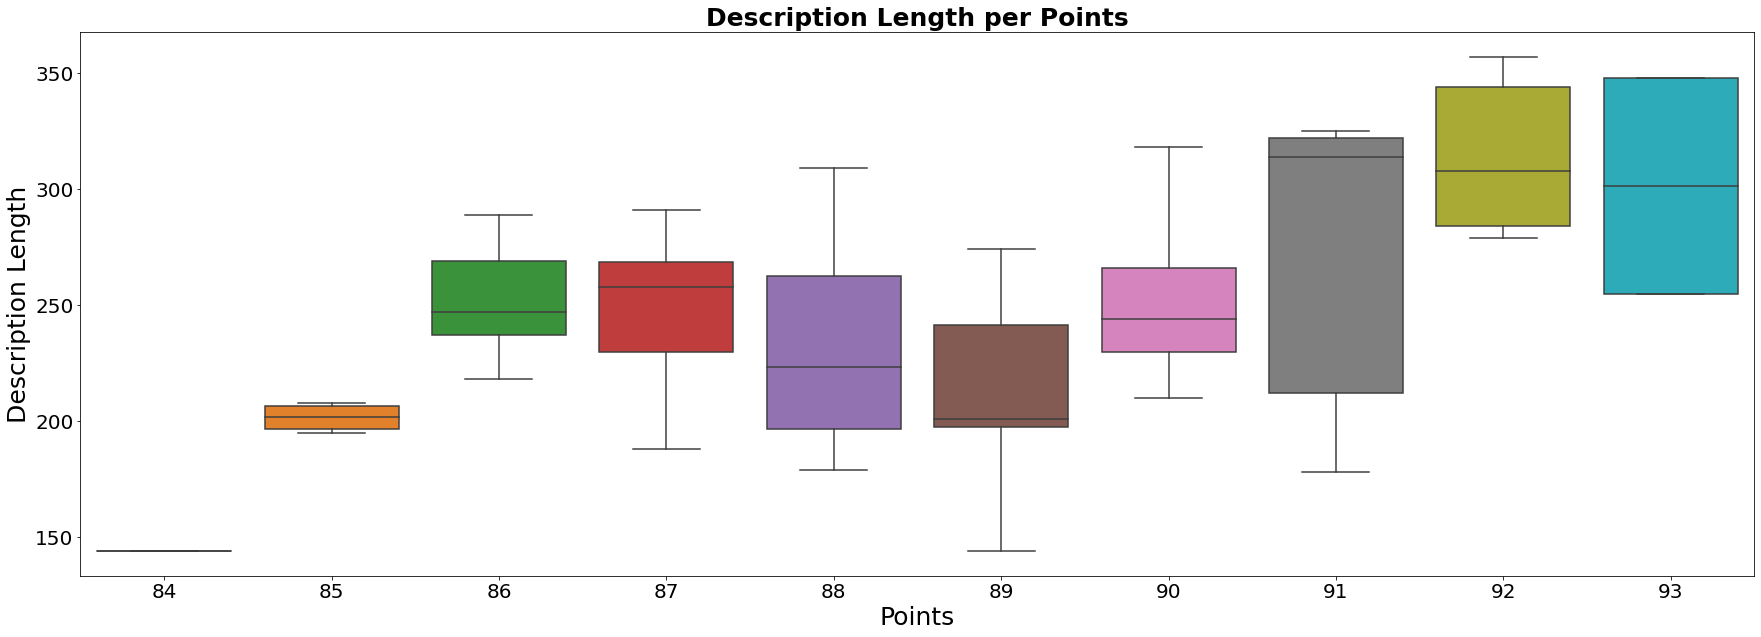

In [7]:
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='points', y='description_length', data=dp)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Points', fontweight="bold", size=25) # Title
ax.set_ylabel('Description Length', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
plt.show()

Inspecting the plot, we can conclude that our initial assumption that the better the quality of wine, the longer its description might be, was correct. 
Since we have a pretty large range of points to deal with, it is better to simplify the points for ease of understanding and evaluation.
We give a value of 1, 2, 3, and 4 for points under the range of 0-84, 85-90, 90-95, 95-100 and respectively such that:
* 0-84: Under Average Wines
* 85-90: Average Wines
* 90-95: Good Wines
* 95-100: Excellent Wines

##### NOTE: EVEN THOUGH THE POINTS ONLY EXTEND FROM 84 TO 93 HERE, THE MODEL IS BUILT UNDER THE ASSUMPTION THAT THE ORIGINAL DATASET WILL HAVE A WIDER RANGE OF POINTS TO EXPLORE.

In [8]:
def transform_points_simplified(points):
    if points < 85:
        return 1
    elif points >= 85 and points < 90:
        return 2 
    elif points >= 90 and points < 95:
        return 3 
    elif points >= 95 and points < 100:
        return 4 
    else:
        return 5
dp = dp.assign(points_simplified = dp['points'].apply(transform_points_simplified))
dp.head()

,description,points,description_length,points_simplified
175,"So ripe and lush with fruit, this could only b...",92,344,3
506,"Despite the low alcohol reading, this comes ac...",90,210,3
555,"Coffee grinds, raisin and baked aromas suggest...",87,232,2
610,Aromas of black cherry and green pepper lead i...,87,258,2
632,This pale salmon rosé is a reliable sparkling ...,90,230,3


Now that the points are simplified, its easier to visualize the range of wines as under average, average, good and excellent wines as seen from the below plot. As expected there's a huge availability of average wines.

<AxesSubplot:title={'center':'Number of wines per points'}, xlabel='points_simplified', ylabel='Number of wines'>

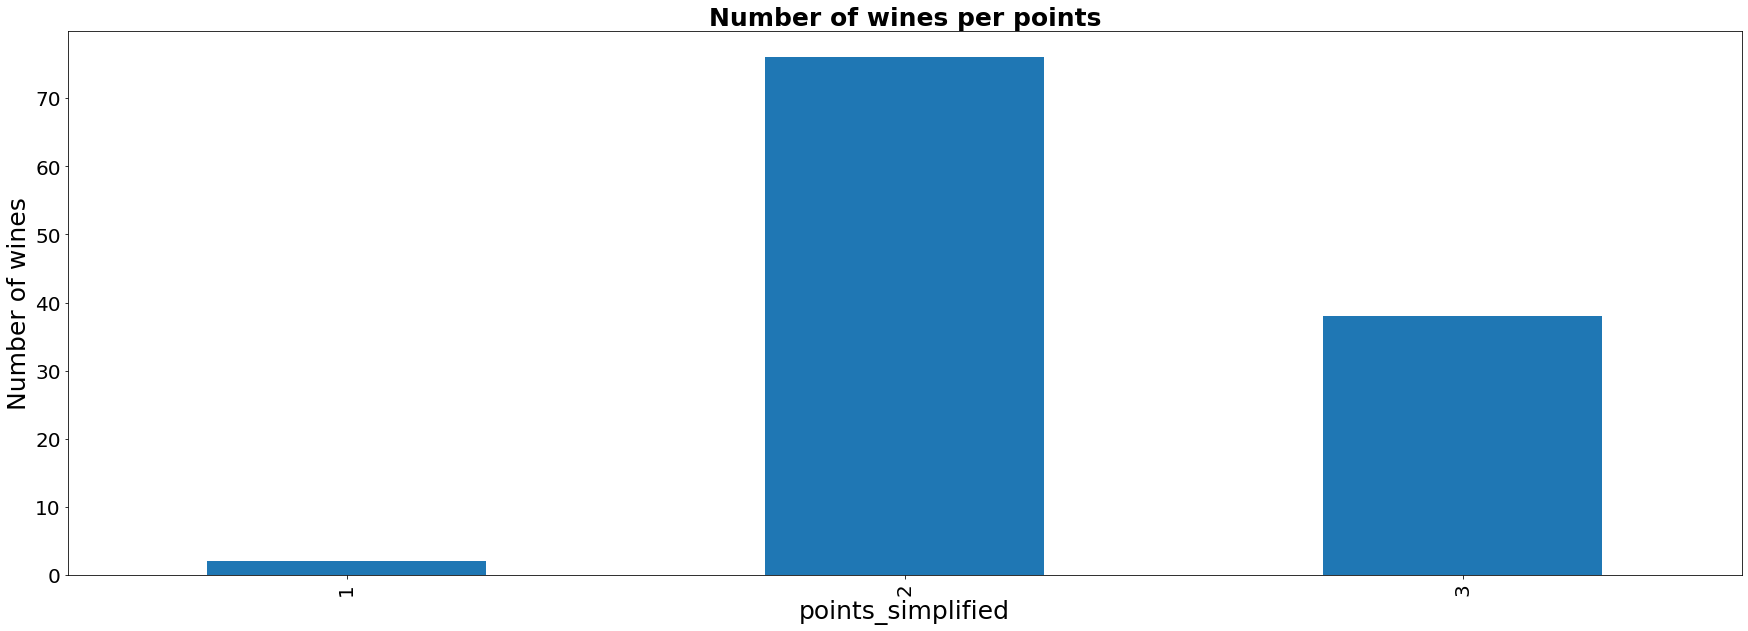

In [9]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of wines per points', fontweight="bold", size=25) # Title
ax.set_ylabel('Number of wines', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
dp.groupby(['points_simplified']).count()['description'].plot(ax=ax, kind='bar')

#### Repeating the steps we did before without simplifying the points reaffirms our initial observations and assumptions regarding the relation between the length of a wine's description and its points.

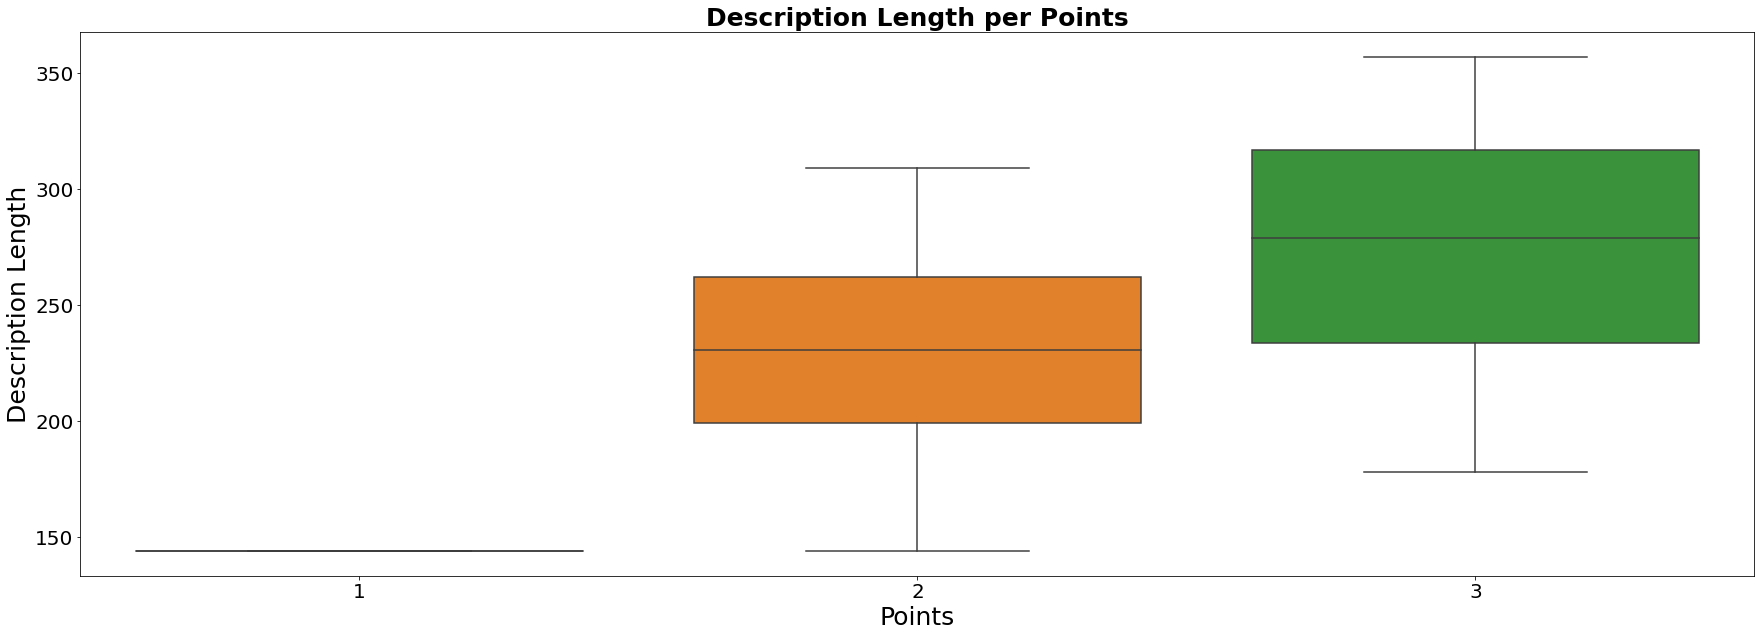

In [10]:
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='points_simplified', y='description_length', data=dp)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Points', fontweight="bold", size=25) # Title
ax.set_ylabel('Description Length', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
plt.show()

# VECTORIZATION

Now that we have established a relationship between the description and the rating of wines, we need to fine tune these parameters to get the best results.
We begin with vectorizing our model. Vectorization is essentially representing our data in a vector space so that it is associatable with lots of its characteristics like number of occurences, length etc.

We will be using TF-IDF Vectorizer, which is one of the most popular vectorization algorithms. Under TF-IDF, the weight of the model increases proportionally to count but it is offset by the frequency of the word in the entire available data. This method is called Inverse Document Frequency, IDF. IDF enables it to adjust the weight with reference to frequent words like,'a', 'the', 'to', 'of' etc


In [11]:
X = dp['description']
y = dp['points_simplified']

# Vectorizing model
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

# Training and Testing the Model:

Now that we have set the parameters and cleansed the data as required, the next step is to actually test the data with a suitable algorithm. We will be using the Random Forest Classifier Algorithm which will give us an accurate prediction by making use of its averaging functionlaity which tends to improve the predictive accuracy and over-all control fitting.

In [12]:
# Training model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)


# Testing model
predictions = rfc.predict(X_test)
print(classification_report(y_test, predictions,))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



# Evaluating the Model

We can check the accuracy of our predictions by making use of Mean Absoluter Percentage Error or MAPE. MAPE is a very useful measure of accuracy as it gives us an understanding of how much our predicted values deviated from the actual values.

In [13]:
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 100.0 %.


# Conclusion

From the obtained accuracy, we can understand that an almost perfect prediction is possible. The initial assumption that people invest more time in describing the best wines acted as the basis of our predictions and helped us understand the direct correlation between how a longer description implies a better vine. Such a high accuracy rate implies that this correlation will hold true for all datasets regardless of its size.

Using this model on a business is mathematically guaranteed to give positive results due to the sheer accuracy with which predictions were made.